## 1. <font color = red> Install and Import the Required Libraries

In [87]:
# Install all the required libraries
!pip install -U -q pdfplumber tiktoken openai chromadb sentence-transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [88]:
# Import all the required Libraries

import pdfplumber
from pathlib import Path
import pandas as pd
from operator import itemgetter
import json
import tiktoken
import openai
import chromadb

In [89]:
try:
    # Mount Google Drive
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
except:
    import dotenv, os
    dotenv.load_dotenv()
    OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
    PPLX_API_KEY = os.getenv("PPLX_API_KEY")

## 2. <font color = red> Read, Process, and Chunk the PDF Files

We will be using [pdfplumber](https://https://pypi.org/project/pdfplumber/) to read and process the PDF files.

`pdfplumber` allows for better parsing of the PDF file as it can read various elements of the PDF apart from the plain text, such as, tables, images, etc. It also offers wide functionaties and visual debugging features to help with advanced preprocessing as well.

In [90]:
# Define the path of the PDF
# single_pdf_path = '/content/drive/MyDrive/HelpMate/Policy Documents/HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf'
# single_pdf_path = "/content/drive/My Drive/HelpMate/Policy Documents/HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf"
single_pdf_path = "Policy Documents/HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf"

#### <font color = red>  2.1 Reading a single PDF file and exploring it through pdfplumber

In [91]:
# Open the PDF file
with pdfplumber.open(single_pdf_path) as pdf:

    # Get one of the pages from the PDF and examine it
    single_page = pdf.pages[6]

    # Extract text from the first page
    text = single_page.extract_text()

    # Extract tables from the first page
    tables = single_page.extract_tables()

    # Print the extracted text
    print(text)

Part C
1. Benefits:
(1) Benefits on Death or diagnosis of contingency covered –
Plan Option Events Benefit
Life Death In the event of the death of the Scheme Member, the
benefit payable shall be the Sum Assured.
Extra Life Option Death In the event of the death of the Scheme Member, the
benefit payable shall be the Sum Assured.
Accidental Death In event of the Scheme Member’s death due to
Accident, an additional death benefit equal to the Sum
Assured will be payable.
This is in addition to the death benefit mentioned
above
Accelerated Critical Illness Death In the event of the death of the Scheme Member, the
Option benefit payable shall be the Sum Assured.
Diagnosis of a In the event of Scheme Member being diagnosed with
Critical Illness any of the covered Critical Illnesses during the Policy
Term, the benefit payable shall be the Sum Assured
and the policy will terminate.
a. The Policy Term, Sum Assured, Cover option, and Mode of Premium Payment will be chosen by Scheme
Member and the

In [92]:
# View the table in the page, if any

tables[0]

[['Plan Option', 'Events', 'Benefit'],
 ['Life',
  'Death',
  'In the event of the death of the Scheme Member, the\nbenefit payable shall be the Sum Assured.'],
 ['Extra Life Option',
  'Death',
  'In the event of the death of the Scheme Member, the\nbenefit payable shall be the Sum Assured.'],
 [None,
  'Accidental Death',
  'In event of the Scheme Member’s death due to\nAccident, an additional death benefit equal to the Sum\nAssured will be payable.\nThis is in addition to the death benefit mentioned\nabove'],
 ['Accelerated Critical Illness\nOption',
  'Death',
  'In the event of the death of the Scheme Member, the\nbenefit payable shall be the Sum Assured.'],
 [None,
  'Diagnosis of a\nCritical Illness',
  'In the event of Scheme Member being diagnosed with\nany of the covered Critical Illnesses during the Policy\nTerm, the benefit payable shall be the Sum Assured\nand the policy will terminate.']]

#### <font color = red> 2.2 Extracting text from multiple PDFs

Let's now try and read multiple documents, extract text from them using appropriate preprocessing, and store them in a dataframe


In [93]:
# Define the path where all pdf documents are present

pdf_path = "Policy Documents/"

In [94]:
# Function to check whether a word is present in a table or not for segregation of regular text and tables

def check_bboxes(word, table_bbox):
    # Check whether word is inside a table bbox.
    l = word['x0'], word['top'], word['x1'], word['bottom']
    r = table_bbox
    return l[0] > r[0] and l[1] > r[1] and l[2] < r[2] and l[3] < r[3]

In [95]:
# Function to extract text from a PDF file.
# 1. Declare a variable p to store the iteration of the loop that will help us store page numbers alongside the text
# 2. Declare an empty list 'full_text' to store all the text files
# 3. Use pdfplumber to open the pdf pages one by one
# 4. Find the tables and their locations in the page
# 5. Extract the text from the tables in the variable 'tables'
# 6. Extract the regular words by calling the function check_bboxes() and checking whether words are present in the table or not
# 7. Use the cluster_objects utility to cluster non-table and table words together so that they retain the same chronology as in the original PDF
# 8. Declare an empty list 'lines' to store the page text
# 9. If a text element in present in the cluster, append it to 'lines', else if a table element is present, append the table
# 10. Append the page number and all lines to full_text, and increment 'p'
# 11. When the function has iterated over all pages, return the 'full_text' list

def extract_text_from_pdf(pdf_path):
    p = 0
    full_text = []


    with pdfplumber.open(pdf_path) as pdf:
        for page in pdf.pages:
            page_no = f"Page {p+1}"
            text = page.extract_text()

            tables = page.find_tables()
            table_bboxes = [i.bbox for i in tables]
            tables = [{'table': i.extract(), 'top': i.bbox[1]} for i in tables]
            non_table_words = [word for word in page.extract_words() if not any(
                [check_bboxes(word, table_bbox) for table_bbox in table_bboxes])]
            lines = []

            for cluster in pdfplumber.utils.cluster_objects(non_table_words + tables, itemgetter('top'), tolerance=5):

                if 'text' in cluster[0]:
                    try:
                        lines.append(' '.join([i['text'] for i in cluster]))
                    except KeyError:
                        pass

                elif 'table' in cluster[0]:
                    lines.append(json.dumps(cluster[0]['table']))


            full_text.append([page_no, " ".join(lines)])
            p +=1

    return full_text

*Now that we have defined the function for extracting the text and tables from a PDF, let's iterate and call this function for all the PDFs in our drive and store them in a list.*

In [96]:
# Define the directory containing the PDF files
pdf_directory = Path(pdf_path)

# Initialize an empty list to store the extracted texts and document names
data = []

# Loop through all files in the directory
for pdf_path in pdf_directory.glob("*.pdf"):

    # Process the PDF file
    print(f"...Processing {pdf_path.name}")

    # Call the function to extract the text from the PDF
    extracted_text = extract_text_from_pdf(pdf_path)

    # Convert the extracted list to a PDF, and add a column to store document names
    extracted_text_df = pd.DataFrame(extracted_text, columns=['Page No.', 'Page_Text'])
    extracted_text_df['Document Name'] = pdf_path.name

    # Append the extracted text and document name to the list
    data.append(extracted_text_df)

    # Print a message to indicate progress
    print(f"Finished processing {pdf_path.name}")

# Print a message to indicate all PDFs have been processed
print("All PDFs have been processed.")

...Processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
Finished processing HDFC-Life-Smart-Pension-Plan-Policy-Document-Online.pdf
...Processing HDFC-Surgicare-Plan-101N043V01.pdf
Finished processing HDFC-Surgicare-Plan-101N043V01.pdf
...Processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
Finished processing HDFC-Life-Group-Poorna-Suraksha-101N137V02-Policy-Document.pdf
...Processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
Finished processing HDFC-Life-Easy-Health-101N110V03-Policy-Bond-Single-Pay.pdf
...Processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
Finished processing HDFC-Life-Sampoorna-Jeevan-101N158V04-Policy-Document (1).pdf
...Processing HDFC-Life-Group-Term-Life-Policy.pdf
Finished processing HDFC-Life-Group-Term-Life-Policy.pdf
...Processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-Policy-Document.pdf
Finished processing HDFC-Life-Sanchay-Plus-Life-Long-Income-Option-101N134V19-

In [97]:
# Concatenate all the DFs in the list 'data' together

insurance_pdfs_data = pd.concat(data, ignore_index=True)

In [98]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name
0,Page 1,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
1,Page 2,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
2,Page 3,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
3,Page 4,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
4,Page 5,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...
...,...,...,...
212,Page 23,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...
213,Page 24,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...
214,Page 25,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...
215,Page 26,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...


In [99]:
# Check one of the extracted page texts to ensure that the text has been correctly read

insurance_pdfs_data.Page_Text[2]

'HDFC Life Smart Pension Plan 101L164V02 – Terms and Conditions (Direct & Online Sales) A Unit Linked Non-Participating Individual Pension Plan [["Name of Appointee, if Nominee is\\nminor", ""], ["Special Conditions", "\\u00abZENDFLD_001\\u00bb\\n\\u00abZENDFLD_002\\u00bb\\n\\u00abZENDFLD_003\\u00bb\\n\\u00abZENDFLD_004\\u00bb\\n\\u00abZENDFLD_005\\u00bb"]] Stamp Duty of Rs. /- is paid as provided under Article 47D(iii) of Indian Stamp Act, 1899 and included in Consolidated Stamp Duty Paid to the Government of Maharashtra Treasury vide Order of Addl. Controller Of Stamps, Mumbai at General Stamp Office, Fort, Mumbai - 400001., vide this Order No.(LOA/CSD/150/2021/Validity Period Dt.07/10/2021 To Dt.31/03/2022 (O/w.No.4088)/Date : 07/10/2021). «Legend_schedule»«ADDAMT» Page 3 of 37'

In [100]:
# Let's also check the length of all the texts as there might be some empty pages or pages with very few words that we can drop

insurance_pdfs_data['Text_Length'] = insurance_pdfs_data['Page_Text'].apply(lambda x: len(x.split(' ')))

In [101]:
insurance_pdfs_data['Text_Length']

0      365
1      266
2       93
3      526
4      588
      ... 
212    793
213    789
214     65
215    670
216     65
Name: Text_Length, Length: 217, dtype: int64

In [102]:
# Retain only the rows with a text length of at least 10

insurance_pdfs_data = insurance_pdfs_data.loc[insurance_pdfs_data['Text_Length'] >= 10]
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length
0,Page 1,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,365
1,Page 2,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,266
2,Page 3,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,93
3,Page 4,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,526
4,Page 5,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,588
...,...,...,...,...
212,Page 23,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...,793
213,Page 24,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...,789
214,Page 25,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...,65
215,Page 26,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...,670


In [103]:
# Store the metadata for each page in a separate column

insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)

/tmp/ipykernel_23094/1081778557.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  insurance_pdfs_data['Metadata'] = insurance_pdfs_data.apply(lambda x: {'Policy_Name': x['Document Name'][:-4], 'Page_No.': x['Page No.']}, axis=1)


In [104]:
insurance_pdfs_data

,Page No.,Page_Text,Document Name,Text_Length,Metadata
0,Page 1,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,365,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
1,Page 2,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,266,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
2,Page 3,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,93,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
3,Page 4,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,526,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
4,Page 5,HDFC Life Smart Pension Plan 101L164V02 – Term...,HDFC-Life-Smart-Pension-Plan-Policy-Document-O...,588,{'Policy_Name': 'HDFC-Life-Smart-Pension-Plan-...
...,...,...,...,...,...
212,Page 23,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...,793,{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...
213,Page 24,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...,789,{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...
214,Page 25,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...,65,{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...
215,Page 26,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,HDFC-Life-Sanchay-Plus-Life-Long-Income-Option...,670,{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...


This concludes the chunking aspect also, as we can see that mostly the pages contain few hundred words, maximum going upto 1000. So, we don't need to chunk the documents further; we can perform the embeddings on individual pages. This strategy makes sense for 2 reasons:
1. The way insurance documents are generally structured, you will not have a lot of extraneous information in a page, and all the text pieces in that page will likely be interrelated.
2. We want to have larger chunk sizes to be able to pass appropriate context to the LLM during the generation layer.

## 3. <font color = red> Generate and Store Embeddings using OpenAI and ChromaDB

In this section, we will embed the pages in the dataframe through OpenAI's `text-embedding-ada-002` model, and store them in a ChromaDB collection.

In [105]:
'''
# Set the API key
filepath = "/content/drive/MyDrive/HelpMate/"

with open(filepath + "OpenAI_API_Key.txt", "r") as f:
  openai.api_key = ' '.join(f.readlines())
'''

'\n# Set the API key\nfilepath = "/content/drive/MyDrive/HelpMate/"\n\nwith open(filepath + "OpenAI_API_Key.txt", "r") as f:\n  openai.api_key = \' \'.join(f.readlines())\n'

In [106]:
# Import the OpenAI Embedding Function into chroma

from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

In [107]:
# Define the path where chroma collections will be stored

chroma_data_path = '/content/drive/MyDrive/HelpMate/ChromaDB_Data'

In [108]:
import chromadb

In [109]:
# Call PersistentClient()

client = chromadb.PersistentClient()

In [110]:
# Set up the embedding function using the OpenAI embedding model

model = "text-embedding-ada-002"
embedding_function = OpenAIEmbeddingFunction(api_key=OPENAI_API_KEY, model_name=model)

In [111]:
# Initialise a collection in chroma and pass the embedding_function to it so that it used OpenAI embeddings to embed the documents

insurance_collection = client.get_or_create_collection(name='RAG_on_Insurance', embedding_function=embedding_function)

In [112]:
# Convert the page text and metadata from your dataframe to lists to be able to pass it to chroma

documents_list = insurance_pdfs_data["Page_Text"].tolist()
metadata_list = insurance_pdfs_data['Metadata'].tolist()

In [113]:
# Add the documents and metadata to the collection alongwith generic integer IDs. You can also feed the metadata information as IDs by combining the policy name and page no.

insurance_collection.add(
    documents= documents_list,
    ids = [str(i) for i in range(0, len(documents_list))],
    metadatas = metadata_list
)

In [114]:
# Let's take a look at the first few entries in the collection

insurance_collection.get(
    ids = ['0','1','2'],
    include = ['embeddings', 'documents', 'metadatas']
)

{'ids': ['0', '1', '2'],
 'embeddings': array([[-0.00454407,  0.00542792,  0.01487027, ..., -0.01147656,
         -0.0112809 , -0.023223  ],
        [-0.0028945 ,  0.01137608,  0.01119433, ..., -0.01376573,
         -0.02452924, -0.02972589],
        [-0.00656162,  0.00761065,  0.00063336, ..., -0.01332893,
         -0.0068633 , -0.03307549]], shape=(3, 1536)),
 'documents': ['HDFC Life Smart Pension Plan 101L164V02 – Terms and Conditions (Direct & Online Sales) A Unit Linked Non-Participating Individual Pension Plan PART A: Covering Letter with Policy Schedule __________________ <dd-mm-yyyy> __________________ __________________ __________________ __________________ Policy Number: __________________ Your <Policy Name UIN> with Policy No. <Policy no.> Dear Mr./Ms.___________________________, Thank you for choosing HDFC Life Insurance as your preferred life insurance solution provider. We are pleased to enclose your Policy Bond, which carries the following details of your recently purch

In [115]:
cache_collection = client.get_or_create_collection(name='Insurance_Cache', embedding_function=embedding_function)

In [116]:
cache_collection.peek()

{'ids': ['what are the benefits in case of death'],
 'embeddings': array([[ 0.01432632, -0.00687885,  0.00397684, ...,  0.0007151 ,
         -0.00106789, -0.01474238]], shape=(1, 1536)),
 'documents': ['what are the benefits in case of death'],
 'uris': None,
 'included': ['metadatas', 'documents', 'embeddings'],
 'data': None,
 'metadatas': [{'ids2': '133',
   'documents6': 'HDFC Life Smart Pension Plan 101L164V02 – Terms and Conditions (Direct & Online Sales) (A Unit Linked Non-Participating Individual Pension Plan) F.12 Suicide Exclusion: In case of death due to suicide within 12 months from the Date of Commencement of the Policy or from the date of Revival of the Policy, as applicable, the Eligible Person shall be entitled to the Fund Value, as available on the date of intimation of death. Further any charges other than Fund Management charges (FMC) recovered subsequent to the date of death shall be added back to the Fund Value as available on the date of intimation of death. F.13 

## 4. <font color = red> Semantic Search with Cache

In this section, we will perform a semantic search of a query in the collections embeddings to get several top semantically similar results.

In [117]:
# Read the user query

query = input()

In [118]:
# Searh the Cache collection first
# Query the collection against the user query and return the top 20 results

cache_results = cache_collection.query(
    query_texts=query,
    n_results=1
)

In [119]:
cache_results

{'ids': [['what are the benefits in case of death']],
 'embeddings': None,
 'documents': [['what are the benefits in case of death']],
 'uris': None,
 'included': ['metadatas', 'documents', 'distances'],
 'data': None,
 'metadatas': [[{'documents7': 'HDFC Life Sanchay Plus (UIN – 101N134V19) – Appendix 9 (c) – Policy Bond A non-participating, non-linked savings insurance plan Part F (General Terms & Conditions) 1. Suicide Exclusions In case of death due to suicide within 12 months from the date of commencement of risk under the policy or from the date of revival of the policy, as applicable, the nominee or beneficiary of the policyholder shall be entitled to at least 80% of the total premiums paid till the date of death or the surrender value available as on the date of death whichever is higher, provided the policy is in force. 2. Age Admitted The Company has calculated the Premiums under the Policy on the basis of the age of the Life Assured as declared in the Proposal. In case you h

In [120]:
results = insurance_collection.query(
query_texts=query,
n_results=10
)
# results.items()

In [121]:
# Implementing Cache in Semantic Search

# Set a threshold for cache search
threshold = 0.2

ids = []
documents = []
distances = []
metadatas = []
results_df = pd.DataFrame()


# If the distance is greater than the threshold, then return the results from the main collection.

if cache_results['distances'][0] == [] or cache_results['distances'][0][0] > threshold:
      # Query the collection against the user query and return the top 10 results
      results = insurance_collection.query(
      query_texts=query,
      n_results=10
      )

      # Store the query in cache_collection as document w.r.t to ChromaDB so that it can be embedded and searched against later
      # Store retrieved text, ids, distances and metadatas in cache_collection as metadatas, so that they can be fetched easily if a query indeed matches to a query in cache
      Keys = []
      Values = []

      for key, val in results.items():
        if val is None:
          continue
        for i in range(min(10, len(val[0]))):
          Keys.append(str(key)+str(i))
          Values.append(str(val[0][i]))
        # Fill remaining slots if needed
        for i in range(len(val[0]), 10):
          Keys.append(str(key)+str(i))
          Values.append("")


      cache_collection.add(
          documents= [query],
          ids = [query],  # Or if you want to assign integers as IDs 0,1,2,.., then you can use "len(cache_results['documents'])" as will return the no. of queries currently in the cache and assign the next digit to the new query."
          metadatas = dict(zip(Keys, Values))
      )

      print("Not found in cache. Found in main collection.")

      result_dict = {'Metadatas': results['metadatas'][0], 'Documents': results['documents'][0], 'Distances': results['distances'][0], "IDs":results["ids"][0]}
      results_df = pd.DataFrame.from_dict(result_dict)
      results_df


# If the distance is, however, less than the threshold, you can return the results from cache

elif cache_results['distances'][0][0] <= threshold:
      cache_result_dict = cache_results['metadatas'][0][0]

      # Loop through each inner list and then through the dictionary
      for key, value in cache_result_dict.items():
          if 'ids' in key:
              ids.append(value)
          elif 'documents' in key:
              documents.append(value)
          elif 'distances' in key:
              distances.append(value)
          elif 'metadatas' in key:
              metadatas.append(value)

      print("Found in cache!")

      # Create a DataFrame
      results_df = pd.DataFrame({
        'IDs': ids,
        'Documents': documents,
        'Distances': distances,
        'Metadatas': metadatas
      })


Found in cache!


In [122]:
results_df

,IDs,Documents,Distances,Metadatas
0,120,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.3714788556098938,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...
1,133,"[[""21. Progressive\nScleroderma"", ""22. Muscula...",0.344705194234848,"{'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L..."
2,195,PART C Product Core Benefits BENEFITS PAYABLE ...,0.3698332905769348,{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...
3,59,"Note: For the purpose of waiting period, Date ...",0.3689667582511902,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
4,58,PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...,0.36598679423332214,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...
5,7,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.35692423582077026,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
6,66,"(i) Death Certificate, in original, issued by ...",0.35701069235801697,"{'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L..."
7,163,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.3648167848587036,"{'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li..."
8,22,Part C 1. Benefits: (1) Benefits on Death or d...,0.37220728397369385,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li..."


## 5. <font color = red> Re-Ranking with a Cross Encoder

Re-ranking the results obtained from your semantic search can sometime significantly improve the relevance of the retrieved results. This is often done by passing the query paired with each of the retrieved responses into a cross-encoder to score the relevance of the response w.r.t. the query.

<br>

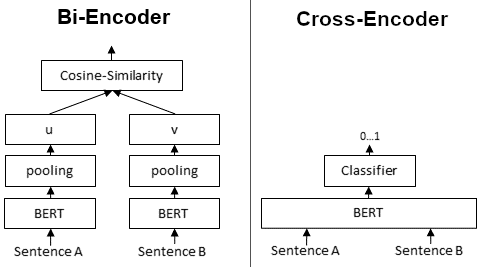

<br>

In [123]:
# Import the CrossEncoder library from sentence_transformers

from sentence_transformers import CrossEncoder, util

In [124]:
# Initialise the cross encoder model

cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-6-v2')

In [125]:
# Test the cross encoder model

scores = cross_encoder.predict([['Does the insurance cover diabetic patients?', 'The insurance policy covers some pre-existing conditions including diabetes, heart diseases, etc. The policy does not howev'],
                                ['Does the insurance cover diabetic patients?', 'The premium rates for various age groups are given as follows. Age group (<18 years): Premium rate']])

In [126]:
scores

array([  3.8467648, -11.252877 ], dtype=float32)

In [127]:
# Input (query, response) pairs for each of the top 20 responses received from the semantic search to the cross encoder
# Generate the cross_encoder scores for these pairs

cross_inputs = [[query, response] for response in results_df['Documents']]
cross_rerank_scores = cross_encoder.predict(cross_inputs)

In [128]:
cross_rerank_scores

array([-2.4994187, -5.2232265, -1.0748789,  5.3742886,  1.7628243,
       -1.3263037, -3.2011807, -4.9767227,  3.5423384], dtype=float32)

In [129]:
# Store the rerank_scores in results_df

results_df['Reranked_scores'] = cross_rerank_scores

In [130]:
results_df

,IDs,Documents,Distances,Metadatas,Reranked_scores
0,120,HDFC Life Sanchay Plus (UIN – 101N134V19) – Ap...,0.3714788556098938,{'Policy_Name': 'HDFC-Life-Group-Term-Life-Pol...,-2.499419
1,133,"[[""21. Progressive\nScleroderma"", ""22. Muscula...",0.344705194234848,"{'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L...",-5.223227
2,195,PART C Product Core Benefits BENEFITS PAYABLE ...,0.3698332905769348,{'Policy_Name': 'HDFC-Life-Sanchay-Plus-Life-L...,-1.074879
3,59,"Note: For the purpose of waiting period, Date ...",0.3689667582511902,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,5.374289
4,58,PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...,0.36598679423332214,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...,1.762824
5,7,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.35692423582077026,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,-1.326304
6,66,"(i) Death Certificate, in original, issued by ...",0.35701069235801697,"{'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L...",-3.201181
7,163,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.3648167848587036,"{'Page_No.': 'Page 7', 'Policy_Name': 'HDFC-Li...",-4.976723
8,22,Part C 1. Benefits: (1) Benefits on Death or d...,0.37220728397369385,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...",3.542338


In [131]:
# Return the top 3 results from semantic search

top_3_semantic = results_df.sort_values(by='Distances')
top_3_semantic[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
1,133,"[[""21. Progressive\nScleroderma"", ""22. Muscula...",0.344705194234848,"{'Page_No.': 'Page 19', 'Policy_Name': 'HDFC-L...",-5.223227
5,7,HDFC Life Smart Pension Plan 101L164V02 – Term...,0.35692423582077026,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,-1.326304
6,66,"(i) Death Certificate, in original, issued by ...",0.35701069235801697,"{'Page_No.': 'Page 23', 'Policy_Name': 'HDFC-L...",-3.201181


In [132]:
# Return the top 3 results after reranking

top_3_rerank = results_df.sort_values(by='Reranked_scores', ascending=False)
top_3_rerank[:3]

,IDs,Documents,Distances,Metadatas,Reranked_scores
3,59,"Note: For the purpose of waiting period, Date ...",0.3689667582511902,{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...,5.374289
8,22,Part C 1. Benefits: (1) Benefits on Death or d...,0.37220728397369385,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li...",3.542338
4,58,PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...,0.36598679423332214,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...,1.762824


In [133]:
top_3_RAG = top_3_rerank[["Documents", "Metadatas"]][:3]

In [134]:
top_3_RAG

,Documents,Metadatas
3,"Note: For the purpose of waiting period, Date ...",{'Policy_Name': 'HDFC-Life-Group-Poorna-Suraks...
8,Part C 1. Benefits: (1) Benefits on Death or d...,"{'Page_No.': 'Page 8', 'Policy_Name': 'HDFC-Li..."
4,PART C PRODUCT CORE BENEFITS BENEFITS PAYABLE ...,{'Policy_Name': 'HDFC-Life-Sampoorna-Jeevan-10...


## 6. Retrieval Augmented Generation

Now that we have the final top search results, we can pass it to an GPT 3.5 along with the user query and a well-engineered prompt, to generate a direct answer to the query along with citations, rather than returning whole pages/chunks.

In [135]:
# Define the function to generate the response. Provide a comprehensive prompt that passes the user query and the top 3 results to the model

def generate_response(query, results_df):
    """
    Generate a response using GPT-3.5's ChatCompletion based on the user query and retrieved information.
    """
    messages = [
                {"role": "system", "content":  "You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents."},
                {"role": "user", "content": f"""You are a helpful assistant in the insurance domain who can effectively answer user queries about insurance policies and documents.
                                                You have a question asked by the user in '{query}' and you have some search results from a corpus of insurance documents in the dataframe '{top_3_RAG}'. These search results are essentially one page of an insurance document that may be relevant to the user query.

                                                The column 'documents' inside this dataframe contains the actual text from the policy document and the column 'metadata' contains the policy name and source page. The text inside the document may also contain tables in the format of a list of lists where each of the nested lists indicates a row.

                                                Use the documents in '{top_3_RAG}' to answer the query '{query}'. Frame an informative answer and also, use the dataframe to return the relevant policy names and page numbers as citations.

                                                Follow the guidelines below when performing the task.
                                                1. Try to provide relevant/accurate numbers if available.
                                                2. You don’t have to necessarily use all the information in the dataframe. Only choose information that is relevant.
                                                3. If the document text has tables with relevant information, please reformat the table and return the final information in a tabular in format.
                                                3. Use the Metadatas columns in the dataframe to retrieve and cite the policy name(s) and page numbers(s) as citation.
                                                4. If you can't provide the complete answer, please also provide any information that will help the user to search specific sections in the relevant cited documents.
                                                5. You are a customer facing assistant, so do not provide any information on internal workings, just answer the query directly.

                                                The generated response should answer the query directly addressing the user and avoiding additional information. If you think that the query is not relevant to the document, reply that the query is irrelevant. Provide the final response as a well-formatted and easily readable text along with the citation. Provide your complete response first with all information, and then provide the citations.
                                                """},
              ]

    response = openai.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages
    )

    return response.choices[0].message.content.split('\n')

In [136]:
# Generate the response

response = generate_response(query, top_3_RAG)

In [137]:
# Print the response

print("\n".join(response))

In case of accidental death, the benefits from the insurance policy may include payments to the nominee or beneficiary.                                              

Here are the policy details related to benefits on accidental death from the insurance documents provided:

| Policy Name                           | Page No. |
|---------------------------------------|----------|
| HDFC-Life-Group-Poorna-Suraksha      |         -|
| HDFC-Life-Sampoorna-Jeevan-10        |       8  |

For detailed information on the benefits in case of accidental death, please refer to the relevant sections in the cited policy documents.
